In [202]:
import numpy as np

In [269]:
data = np.loadtxt('../data/extracts/recordings/lidar_test_005_mins_baseline.csv', delimiter=',').T

In [270]:
gt = np.loadtxt('../data/extracts/groundtruth/lidar_test_005.csv', delimiter=',').T

In [271]:
dt_min, dt_max = data[0][[0, -1]]

In [209]:
gt_min, gt_max = gt[0][[0, -1]]

In [210]:
gt_max - dt_min

-524600746430464.0

In [211]:
from datetime import datetime

In [212]:
print("dt min", datetime.fromtimestamp(dt_min / 1e9))
print("gt min", datetime.fromtimestamp(gt_min / 1e9))
print("dt max", datetime.fromtimestamp(dt_max / 1e9))
print("gt max", datetime.fromtimestamp(gt_max / 1e9))

dt min 2024-07-21 13:50:46.634357
gt min 2024-07-15 12:06:41.233717
dt max 2024-07-21 13:51:28.102302
gt max 2024-07-15 12:07:25.887927


In [213]:
print((dt_max - dt_min) / 1e9)
print((gt_max - gt_min) / 1e9)

41.46794496
44.654209792


In [214]:
import matplotlib.pyplot as plt

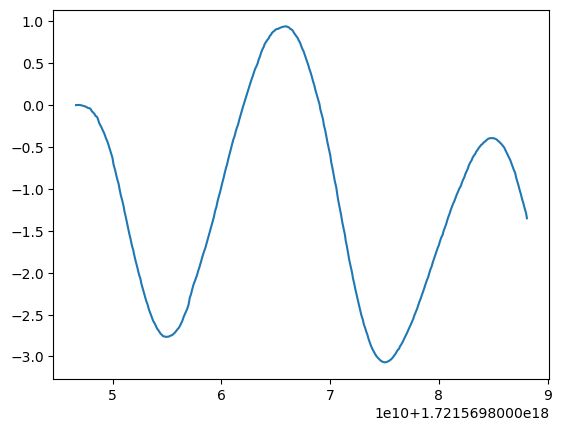

In [215]:
plt.plot(data[0], data[1], label='mins')

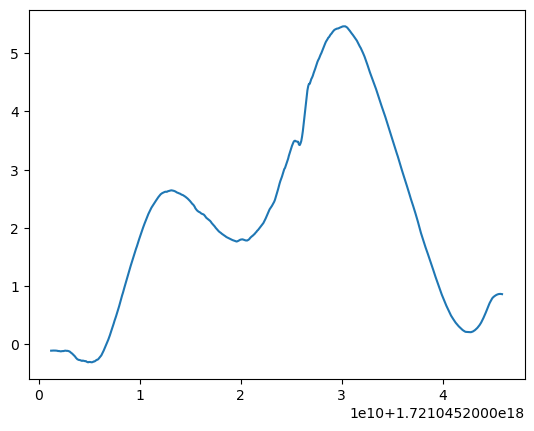

In [216]:
plt.plot(gt[0], -gt[1], label='mins')

In [217]:
gt[:, 0]

array([ 1.72104520e+18,  1.07877646e-01, -2.15001079e+00])

In [218]:
gt = gt.T - gt[:, 0]
data = data.T - data[:, 0]

In [219]:
data[-1, :]

array([ 4.14679450e+10, -1.34983081e+00, -5.67627870e-01,  2.45448924e-02])

In [220]:
gt[-1, :]

array([ 4.46542098e+10, -9.70574470e-01, -1.57580869e+00])

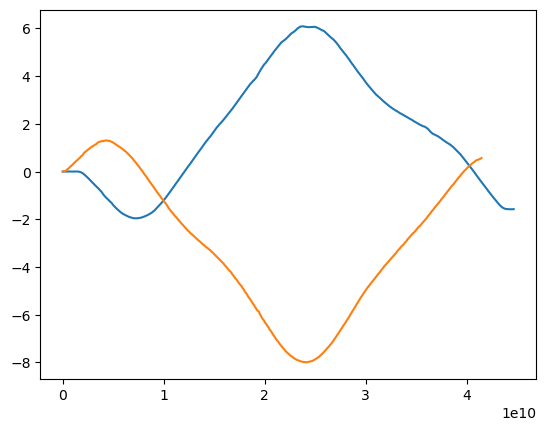

In [221]:
plt.plot(gt[:, 0], gt[:, 2], label='gt')

plt.plot(data[:, 0], -data[:, 2], label='data')

plt.show()

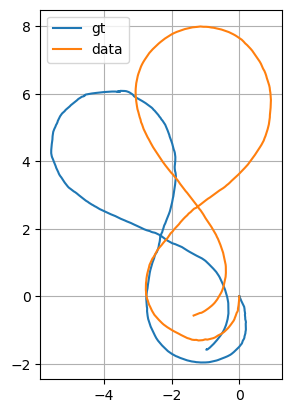

In [222]:
plt.plot(gt[:, 1], gt[:, 2], label='gt')
plt.plot(data[:, 1], data[:, 2], label='data')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.grid()
plt.show()

In [223]:
from scipy.interpolate import splprep, splev
from scipy.spatial import procrustes

In [224]:
tck_data, u_data = splprep(data.T[[1, 2]], s=0)

In [225]:
new_u = np.linspace(0, 1, len(gt))

In [226]:
interp_data = np.array(splev(new_u, tck_data)).T

In [227]:
interp_data

array([[-7.40893746e-21, -8.04841346e-18],
       [ 1.85136174e-03, -4.35450591e-02],
       [-5.54801693e-04, -8.73495916e-02],
       ...,
       [-1.26809639e+00, -5.36337179e-01],
       [-1.30929071e+00, -5.50934719e-01],
       [-1.34983081e+00, -5.67627870e-01]])

In [228]:
gt_coords = gt[:, 1:]

In [229]:
disp, mtx1, mtx2 = procrustes(gt_coords, interp_data)

In [686]:
def rotate_translate(coords, theta, tx, ty):
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], 
                                [np.sin(theta), np.cos(theta)]])
    transformed_coords = coords.dot(rotation_matrix)
    # transformed_coords[:, 0] += tx
    # transformed_coords[:, 1] += ty
    return transformed_coords

def objective_function(params, recording_coords, groundtruth_coords):
    theta, tx, ty = params
    transformed_coords = rotate_translate(recording_coords, theta, tx, ty)
    error = np.sum((transformed_coords - groundtruth_coords) ** 2)
    return error

In [687]:
from scipy.optimize import minimize

In [688]:
#plt.plot(gt_coords[:, 0], gt_coords[:, 1], label='Ground Truth')
initial_params = [0, 0, 0]
result = minimize(objective_function, initial_params, args=(interp_data, gt_coords), 
                  method='Powell')

opt = result.x

transformed_coords = rotate_translate(interp_data, *opt)

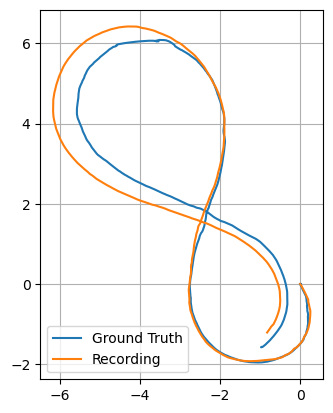

In [689]:
plt.plot(gt_coords[:, 0], gt_coords[:, 1], label='Ground Truth')
plt.plot(transformed_coords[:, 0], transformed_coords[:, 1], label='Recording')
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()

In [690]:
def rotate_to_gt(data, gt):
    gt = gt.T - gt[:, 0]
    data = data.T - data[:, 0]
    
    tck_data, u_data = splprep(data.T[[1, 2]], s=0)
    new_u = np.linspace(0, 1, len(gt))

    interp_data = np.array(splev(new_u, tck_data)).T
    initial_params = [0, 0, 0]

    gt_coords = gt[:, 1:]

    result = minimize(
        objective_function,
        initial_params,
        args=(interp_data, gt_coords),
        method='Powell'
    )

    opt = result.x
    transformed_coords = rotate_translate(data.T[[1,2]].T, *opt)

    return gt.T, np.vstack([data.T[0], transformed_coords.T])

In [703]:

data = np.loadtxt('../data/extracts/recordings/lidar_test_008_mins_clahe.csv', delimiter=',').T
gt = np.loadtxt('../data/extracts/groundtruth/lidar_test_008.csv', delimiter=',').T

gt, x = rotate_to_gt(data, gt)

In [704]:
gt.shape

(3, 496)

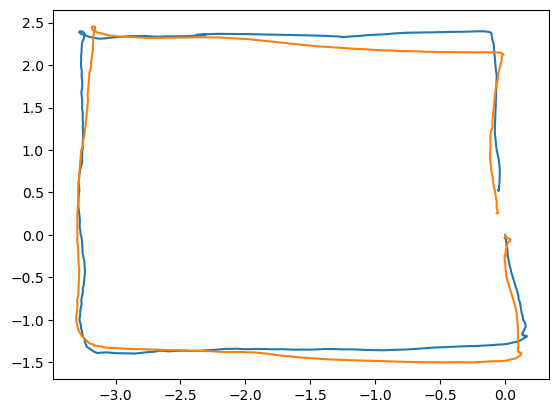

In [705]:
plt.plot(gt[ 1], gt[2])
plt.plot(x[ 1], x[2])
plt.show()

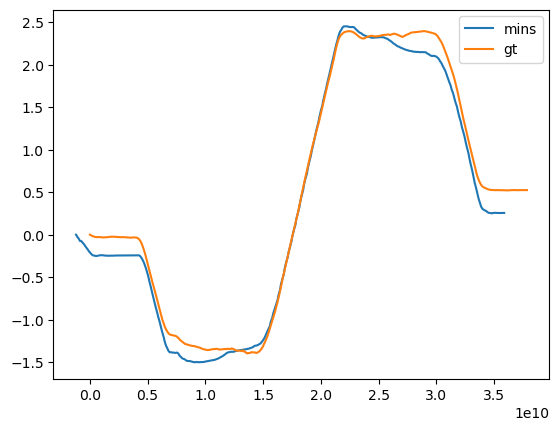

In [706]:
plt.plot(x[0] - 1200000000, x[2], label='mins')
plt.plot(gt[0], gt[2], label='gt')
plt.legend()

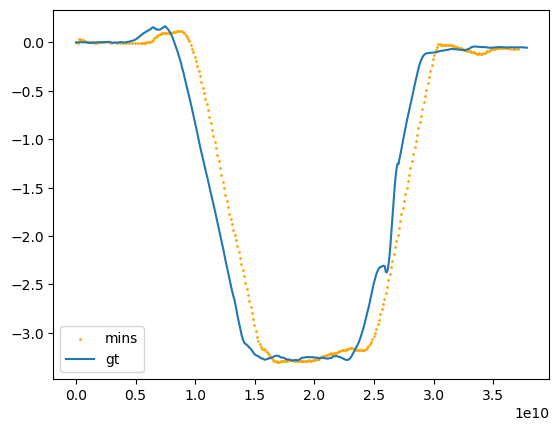

In [707]:
plt.scatter(x[0], x[1], label='mins', s=1, c='orange')
plt.plot(gt[0], gt[1], label='gt')
plt.legend()

In [708]:
def interpolate_to_common_timebase(gt, x):
    timestamps1 = gt[0]
    x1 = gt[1]
    y1 = gt[2]

    timestamps2 = x[0]
    x2 = x[1]
    y2 = x[2]

    # Interpolating signals to a common time base if necessary
    common_time_base = np.linspace(min(timestamps1[0], timestamps2[0]), max(timestamps1[-1], timestamps2[-1]), num=len(timestamps1))

    x1_interpolated = np.interp(common_time_base, timestamps1, x1)
    y1_interpolated = np.interp(common_time_base, timestamps1, y1)
    x2_interpolated = np.interp(common_time_base, timestamps2, x2)
    y2_interpolated = np.interp(common_time_base, timestamps2, y2)
    
    return x1_interpolated, y1_interpolated, x2_interpolated, y2_interpolated, common_time_base

def align_xy(common_time_base, lag, x2_interpolated, y2_interpolated):
    aligned_x2 = np.interp(common_time_base, common_time_base - lag, x2_interpolated)
    aligned_y2 = np.interp(common_time_base, common_time_base - lag, y2_interpolated)
    return aligned_x2, aligned_y2

# Use the average lag if x and y are expected to have the same shift
def objective_function_lag(lag, common_time_base, x1_interpolated, y1_interpolated, x2_interpolated, y2_interpolated):
    aligned_x2, aligned_y2 = align_xy(common_time_base, lag, x2_interpolated, y2_interpolated)
    error = np.sum((x1_interpolated - aligned_x2) ** 2) + np.sum((y1_interpolated - aligned_y2) ** 2)
    return error

def align_time(gt, x):
    x1_interpolated, y1_interpolated, x2_interpolated, y2_interpolated, common_time_base = interpolate_to_common_timebase(gt, x)
    initial_params = [0]
    result = minimize(objective_function_lag, initial_params, args=(common_time_base, x1_interpolated, y1_interpolated, x2_interpolated, y2_interpolated), method='Powell')
    opt = result.x
    aligned_x2, aligned_y2 = align_xy(common_time_base, *opt, x2_interpolated, y2_interpolated)
    return gt, np.vstack([common_time_base, aligned_x2, aligned_y2])

In [755]:
def measure_error(gt, x):
    error = np.abs(gt_a[1] - x_a[1]) + np.abs(gt_a[2] - x_a[2])
    return error.mean()

In [756]:
def plot_gt_x(gt, x, name):
    error = measure_error(gt, x)
    plt.suptitle(name)
    plt.title(f'Mean Squared Error: {error:.5f}')
    plt.plot(gt[1], gt[2], label='Ground Truth')
    plt.plot(x[1], x[2], label='Recording')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid()
    plt.show()

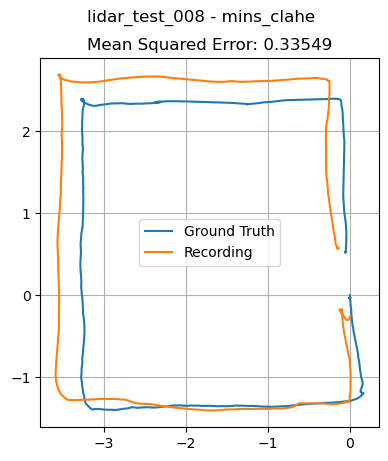

In [757]:

data = np.loadtxt('../data/extracts/recordings/lidar_test_008_mins_long_init.csv', delimiter=',').T
gt = np.loadtxt('../data/extracts/groundtruth/lidar_test_008.csv', delimiter=',').T

gt, x = rotate_to_gt(data, gt)
gt_a, x_a = align_time(gt, x)

plot_gt_x(gt_a, x_a, 'lidar_test_008 - mins_clahe')

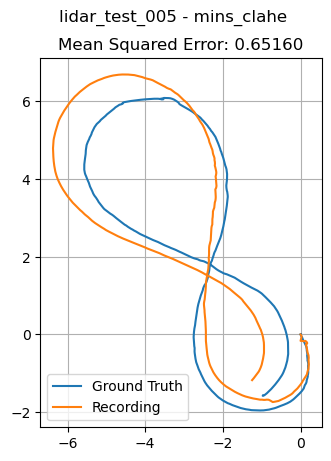

In [758]:
data = np.loadtxt('../data/extracts/recordings/lidar_test_005_mins_long_init.csv', delimiter=',').T
gt = np.loadtxt('../data/extracts/groundtruth/lidar_test_005.csv', delimiter=',').T

gt, x = rotate_to_gt(data, gt)
gt_a, x_a = align_time(gt, x)

plot_gt_x(gt_a, x_a, 'lidar_test_005 - mins_clahe')

In [718]:
measure_error(gt, x)

0.03149154187920917

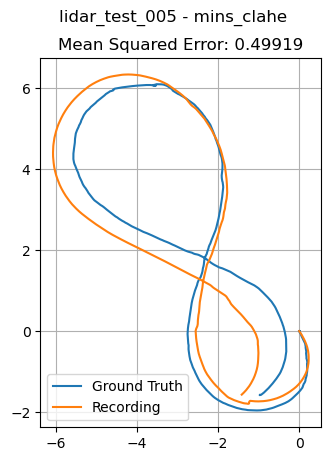

In [759]:

data = np.loadtxt('../data/extracts/recordings/lidar_test_005_mins_many_features.csv', delimiter=',').T
gt = np.loadtxt('../data/extracts/groundtruth/lidar_test_005.csv', delimiter=',').T

gt, x = rotate_to_gt(data, gt)
gt_a, x_a = align_time(gt, x)

plot_gt_x(gt_a, x_a, 'lidar_test_005 - mins_clahe')